# Predecir el SP&500

Vamos a tratar de predecir si el S&P 500 (ETF “SPY”) subirá o bajará la próxima semana, vamos a comprar al inicio de la semana si la probabilidad de “sube” es alta; si no, te quedas en efectivo.

Elegimos el S&P 500 porque es líquido es menos ruidoso que acciones sueltas y tenemos datos gratuitos fáciles de obtener.

Elegimos un Horizonte semanal (5 días) para tener menos “ruido” diario y comisiones.

Por ahora vamos a elegir modelos fáciles de entrenar y mantener.


# Descargar y visualizar datos del ETF SPY (ajustado con fechas en ambas gráficas)

[*********************100%***********************]  1 of 1 completed


Primera fecha con datos: 1990-01-02
Vista rápida de los datos:
                  Open        High         Low       Close     Volume
Date                                                                 
1990-01-02  353.399994  359.690002  351.980011  359.690002  162070000
1990-01-03  359.690002  360.589996  357.890015  358.760010  192330000
1990-01-04  358.760010  358.760010  352.890015  355.670013  177000000
1990-01-05  355.670013  355.670013  351.350006  352.200012  158530000
1990-01-08  352.200012  354.239990  350.540009  353.790009  140110000


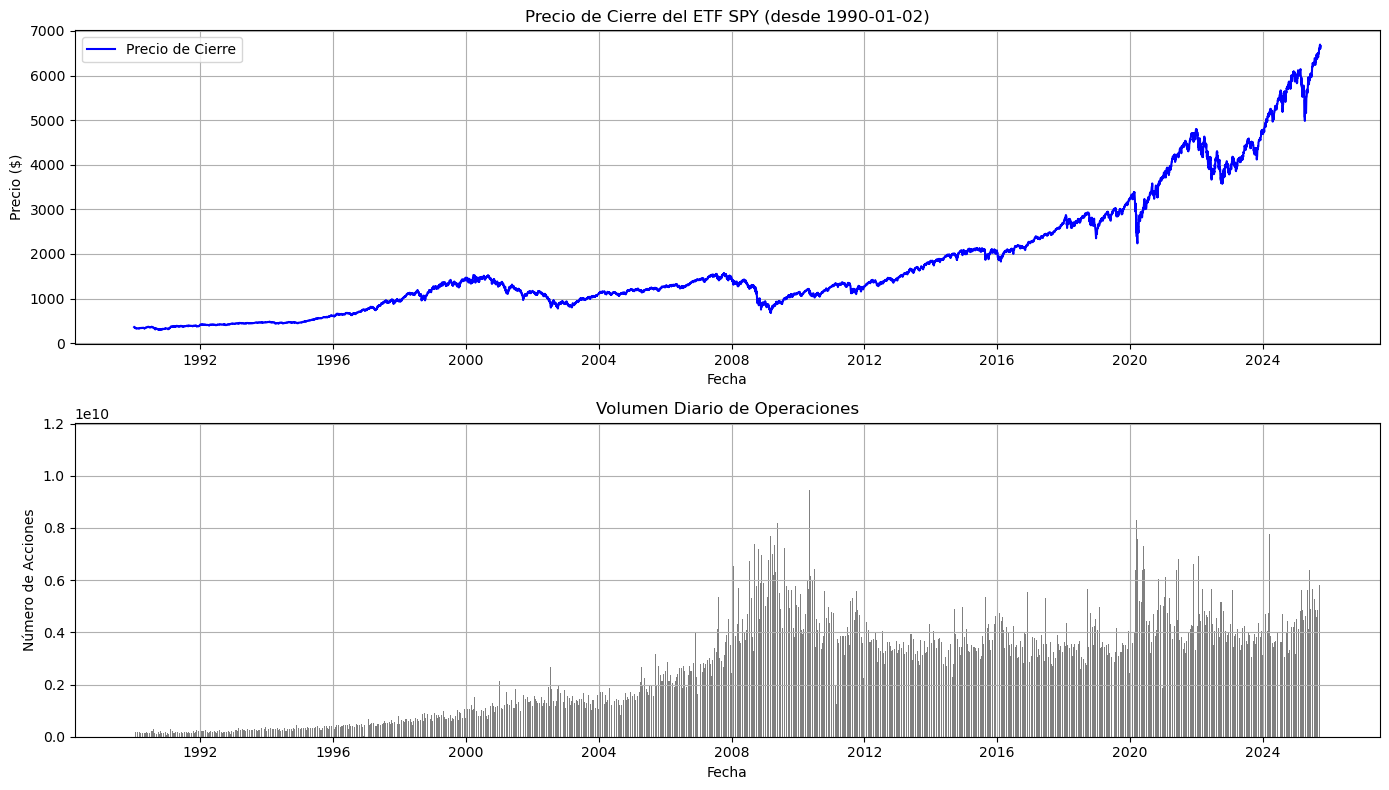

In [42]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np


# Descargar datos desde 1990 por si acaso, y nos quedamos con la primera fecha real
df = yf.download("^GSPC", start="1990-01-01", auto_adjust=True)

# Si hay MultiIndex en las columnas (cuando yfinance mete 'Price', 'Ticker'), lo aplanamos
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [col[0] for col in df.columns]

# Nos quedamos con lo básico
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

# Identificar la primera fecha con datos disponibles
fecha_inicio = df.index.min().strftime("%Y-%m-%d")

# Inspección
print(f"Primera fecha con datos: {fecha_inicio}")
print("Vista rápida de los datos:")
print(df.head())

# Graficar precios y volumen
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,8))

# Precios de cierre
ax1.plot(df.index, df['Close'], label="Precio de Cierre", color="blue")
ax1.set_title(f"Precio de Cierre del ETF SPY (desde {fecha_inicio})")
ax1.set_ylabel("Precio ($)")
ax1.set_xlabel("Fecha")  # el primer gráfico también tiene fechas
ax1.legend()
ax1.grid(True)

# Volumen diario
ax2.bar(df.index, df['Volume'].values, width=1.0, color="gray")
ax2.set_title("Volumen Diario de Operaciones")
ax2.set_ylabel("Número de Acciones")
ax2.set_xlabel("Fecha")
ax2.grid(True)

plt.tight_layout()
plt.show()


# Sacar Features y ver Nans

Este bloque de código construye variables derivadas de la serie histórica de precios y volumen para usarlas en un modelo predictivo. Cada variable tiene un significado concreto:

* **daily\_return\_1d, daily\_return\_5d, daily\_return\_10d, daily\_return\_20d**: son los retornos porcentuales del precio de cierre en distintos horizontes, es decir, cuánto varió el precio respecto a 1, 5, 10 o 20 días atrás.

* **sma\_close\_10d y sma\_close\_20d**: son las medias móviles simples del precio de cierre en ventanas de 10 y 20 días, que suavizan las oscilaciones y muestran la tendencia.

* **price\_vs\_sma10 y price\_vs\_sma20**: miden la distancia relativa del precio actual frente a su media móvil de 10 o 20 días, expresada en porcentaje; indican si el precio está por encima o por debajo de su promedio reciente.

* **volatility\_return\_10d**: es la volatilidad de los retornos diarios en los últimos 10 días, medida como la desviación estándar, que refleja la magnitud de las fluctuaciones recientes.

* **rsi\_strength\_14d**: es el Índice de Fuerza Relativa (RSI) de 14 días, un indicador técnico que evalúa la intensidad de las subidas frente a las bajadas; valores altos sugieren sobrecompra y bajos, sobreventa.

* **volume\_vs\_avg20d**: compara el volumen de operaciones del día con el volumen promedio de los últimos 20 días, mostrando si el interés del mercado está por encima o por debajo de lo habitual.

* **future\_return\_5d**: es el retorno porcentual que tendrá el precio en los próximos 5 días, calculado con datos futuros.

* **target\_up\_next\_5d**: variable binaria derivada del retorno futuro; vale 1 si el precio subirá en los siguientes 5 días y 0 si bajará, y se usa como objetivo del modelo.


# Crear variables con nombres autoexplicativos y objetivo

In [43]:
from ta.momentum import RSIIndicator  # Librería "technical analysis" (ta) que incluye RSI y otros indicadores

# ----------------------------------------
# 1) Retornos pasados (en %)
# ----------------------------------------
# .pct_change(N) calcula el cambio porcentual respecto a N periodos atrás:
# fórmula = (valor_actual / valor_hace_N_periodos) - 1
# Por defecto, N=1 (comparación con el valor anterior inmediato).
df['daily_return_1d']   = df['Close'].pct_change(1)    # retorno del último día
df['daily_return_5d']   = df['Close'].pct_change(5)    # retorno de los últimos 5 días
df['daily_return_10d']  = df['Close'].pct_change(10)   # retorno de los últimos 10 días
df['daily_return_20d']  = df['Close'].pct_change(20)   # retorno de los últimos 20 días

# ----------------------------------------
# 2) Promedios móviles (SMA) y distancia del precio a esos promedios
# ----------------------------------------
# .rolling(N).mean() calcula un promedio móvil simple (SMA) de ventana N
# ejemplo: SMA_10d = promedio de los últimos 10 valores de 'Close'
df['sma_close_10d'] = df['Close'].rolling(10).mean()   # media móvil simple de 10 días
df['sma_close_20d'] = df['Close'].rolling(20).mean()   # media móvil simple de 20 días

# Distancia relativa entre el precio actual y el SMA:
# (Close / SMA) - 1 → resultado en porcentaje
df['price_vs_sma10'] = df['Close']/df['sma_close_10d'] - 1
df['price_vs_sma20'] = df['Close']/df['sma_close_20d'] - 1

# ----------------------------------------
# 3) Volatilidad reciente
# ----------------------------------------
# La volatilidad se suele medir como la desviación estándar (std) de los retornos.
# Aquí usamos la ventana de 10 días.
df['volatility_return_10d'] = df['daily_return_1d'].rolling(10).std()

# ----------------------------------------
# 4) Índice RSI (Relative Strength Index)
# ----------------------------------------
# RSI mide la fuerza relativa de las subidas frente a las bajadas de los últimos N días.
# Valores típicos: >70 = sobrecompra, <30 = sobreventa.
rsi = RSIIndicator(close=df['Close'], window=14)  # RSI de 14 días (ventana típica en análisis técnico)
df['rsi_strength_14d'] = rsi.rsi()                # Devuelve una serie con el RSI

# ----------------------------------------
# 5) Cambio de volumen
# ----------------------------------------
# Comparamos el volumen actual con el promedio de los últimos 20 días:
# (Volumen actual / Volumen promedio_20d) - 1
df['volume_vs_avg20d'] = df['Volume']/df['Volume'].rolling(20).mean() - 1

# ----------------------------------------
# 6) Objetivo (target) para el modelo: retorno futuro a 5 días
# ----------------------------------------
# .shift(-5) "desplaza" los datos 5 filas hacia arriba → el valor de cierre de dentro de 5 días.
# Esto permite calcular el "retorno futuro".
df['future_return_5d'] = df['Close'].shift(-5)/df['Close'] - 1

# Definimos el objetivo como variable binaria:
# 1 = si el retorno a 5 días es positivo (sube el precio), 0 = si baja.
df['target_up_next_5d'] = (df['future_return_5d'] > 0).astype(int)

# ----------------------------------------
# 7) Revisar valores faltantes ANTES de eliminarlos
# ----------------------------------------
features = [
    'daily_return_1d','daily_return_5d','daily_return_10d','daily_return_20d',
    'price_vs_sma10','price_vs_sma20','volatility_return_10d',
    'rsi_strength_14d','volume_vs_avg20d'
]

# .isna().sum() cuenta cuántos NaN (valores faltantes) hay por columna
missing_counts = df[features + ['target_up_next_5d']].isna().sum()
print("Valores faltantes por columna:")
print(missing_counts)


Valores faltantes por columna:
daily_return_1d           1
daily_return_5d           5
daily_return_10d         10
daily_return_20d         20
price_vs_sma10            9
price_vs_sma20           19
volatility_return_10d    10
rsi_strength_14d         13
volume_vs_avg20d         19
target_up_next_5d         0
dtype: int64


los valores faltantes no son errores aleatorios, sino consecuencia natural de los cálculos.

La estrategia más adecuada no es imputar con ceros ni rellenar con medias, ya que eso introduciría información artificial. Tampoco conviene usar forward o backward fill, porque copiarías valores de días donde aún no existía el indicador.

La manera más inteligente es simplemente eliminar esas filas con NaN, ya que corresponden a los primeros días de la serie (falta de historial) o a los últimos (falta de futuro). La pérdida de datos es mínima frente al tamaño total y te asegura que todas las variables y el objetivo estén calculados de forma coherente.

In [44]:

# ----------------------------------------
# 8) Eliminar filas con NaN
# ----------------------------------------
# .dropna(subset=...) elimina filas donde haya NaN en esas columnas
df_model = df.dropna(subset=features + ['target_up_next_5d']).copy()

print("\nDataFrame listo para modelado:")
print(df_model[features + ['target_up_next_5d']].head())


DataFrame listo para modelado:
            daily_return_1d  daily_return_5d  daily_return_10d  \
Date                                                             
1990-01-30        -0.006827        -0.026024         -0.052150   
1990-01-31         0.018887        -0.003573         -0.024659   
1990-02-01        -0.000881         0.008311         -0.027795   
1990-02-02         0.006478         0.015715         -0.024266   
1990-02-05         0.002810         0.020449          0.004449   

            daily_return_20d  price_vs_sma10  price_vs_sma20  \
Date                                                           
1990-01-30         -0.102060       -0.023359       -0.048745   
1990-01-31         -0.082729       -0.002404       -0.026524   
1990-02-01         -0.075576       -0.000435       -0.023500   
1990-02-02         -0.060420        0.008564       -0.014058   
1990-02-05         -0.062014        0.010946       -0.008045   

            volatility_return_10d  rsi_strength_14d  vol

# Contar cantidad de datos disponibles por variable

In [45]:
# Lista completa de variables de interés (features + target)
vars_interes = features + ['target_up_next_5d']

print("Cantidad de datos válidos (no NaN) en cada variable:\n")
print(df_model[vars_interes].count())   # cuenta solo valores no nulos

print("\nTotal de filas en el DataFrame:", len(df))
print("Total de filas sin NaN en todas las variables:",
      df_model[vars_interes].dropna().shape[0])


Cantidad de datos válidos (no NaN) en cada variable:

daily_return_1d          8982
daily_return_5d          8982
daily_return_10d         8982
daily_return_20d         8982
price_vs_sma10           8982
price_vs_sma20           8982
volatility_return_10d    8982
rsi_strength_14d         8982
volume_vs_avg20d         8982
target_up_next_5d        8982
dtype: int64

Total de filas en el DataFrame: 9002
Total de filas sin NaN en todas las variables: 8982


# División temporal, entrenamiento y predicciones

El proceso consiste en tomar el DataFrame limpio creado en la celda 2 y definir las variables predictoras y la variable objetivo.

Luego se realiza una división temporal de los datos, usando información hasta 2019 para el entrenamiento y reservando desde 2020 en adelante para la prueba, garantizando que el modelo solo se entrene con datos pasados.

El modelo inicial será una Regresión Logística de scikit-learn, elegida por su sencillez y facilidad de interpretación, que se ajusta con los datos de entrenamiento.

A continuación se generan predicciones sobre el conjunto de prueba y se evalúa el rendimiento con métricas básicas como la precisión y la proporción de semanas en las que el modelo predice que el precio subirá, además de visualizar la distribución de probabilidades.

Finalmente, se guardan las probabilidades y las etiquetas en un nuevo DataFrame, que servirá para simular la estrategia en la siguiente etapa del análisis.

# División temporal, entrenamiento y predicciones

Tamaño del set de entrenamiento: 8545 filas
Tamaño del set de prueba: 437 filas
Precisión en el conjunto de prueba: 0.629


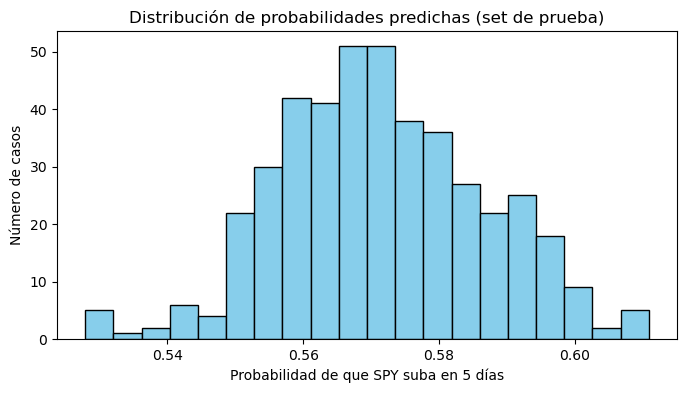

In [46]:
# Importamos librerías para modelado
from sklearn.linear_model import LogisticRegression    # modelo simple y explicativo
from sklearn.metrics import accuracy_score             # métrica de evaluación
import matplotlib.pyplot as plt                        # para graficar

# ------------------------------------------------
# 1) Definir las variables predictoras (features) y el objetivo (target)
# ------------------------------------------------
# X: todas las columnas de variables explicativas (features) creadas en Celda 2
# y: columna binaria que indica si el precio subirá en los próximos 5 días
X = df_model[features]
y = df_model['target_up_next_5d']

# ------------------------------------------------
# 2) Separar los datos en entrenamiento y prueba usando un corte temporal
# ------------------------------------------------
# Aquí decimos: todo lo que ocurra hasta el 31/12/2019 será entrenamiento,
# y lo que ocurra a partir de 2020 será usado como test (simulando el "futuro").
split_date = '2023-12-31'

# Usamos .loc para seleccionar filas por índice de fecha
# -> X.loc[:split_date] significa: "todas las filas desde el inicio hasta esa fecha"
# -> X.loc[split_date:] significa: "todas las filas desde esa fecha en adelante"
X_train, y_train = X.loc[:split_date], y.loc[:split_date]
X_test,  y_test  = X.loc[split_date:], y.loc[split_date:]

print(f"Tamaño del set de entrenamiento: {X_train.shape[0]} filas")
print(f"Tamaño del set de prueba: {X_test.shape[0]} filas")

# ------------------------------------------------
# 3) Entrenar el modelo de Regresión Logística
# ------------------------------------------------
# - max_iter=1000 asegura que el algoritmo tenga suficientes iteraciones para converger.
# - .fit(X_train, y_train) entrena el modelo con los datos de entrenamiento.
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# ------------------------------------------------
# 4) Hacer predicciones en el conjunto de prueba
# ------------------------------------------------
# .predict(X_test) devuelve 0 o 1 directamente (clasificación binaria)
y_pred = model.predict(X_test)

# .predict_proba(X_test) devuelve la probabilidad de cada clase.
# [:,1] significa "dame solo la segunda columna", es decir,
# la probabilidad de que sea la clase 1 (que el mercado suba).
y_prob = model.predict_proba(X_test)[:,1]

# ------------------------------------------------
# 5) Evaluar precisión del modelo en test
# ------------------------------------------------
# accuracy_score compara predicciones (y_pred) contra la realidad (y_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión en el conjunto de prueba: {accuracy:.3f}")

# ------------------------------------------------
# 6) Visualizar las probabilidades predichas
# ------------------------------------------------
# Graficamos un histograma para ver cómo se distribuyen las probabilidades de "sube".
plt.figure(figsize=(8,4))
plt.hist(y_prob, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribución de probabilidades predichas (set de prueba)")
plt.xlabel("Probabilidad de que SPY suba en 5 días")
plt.ylabel("Número de casos")
plt.show()


# Backtest semanal de la estrategia

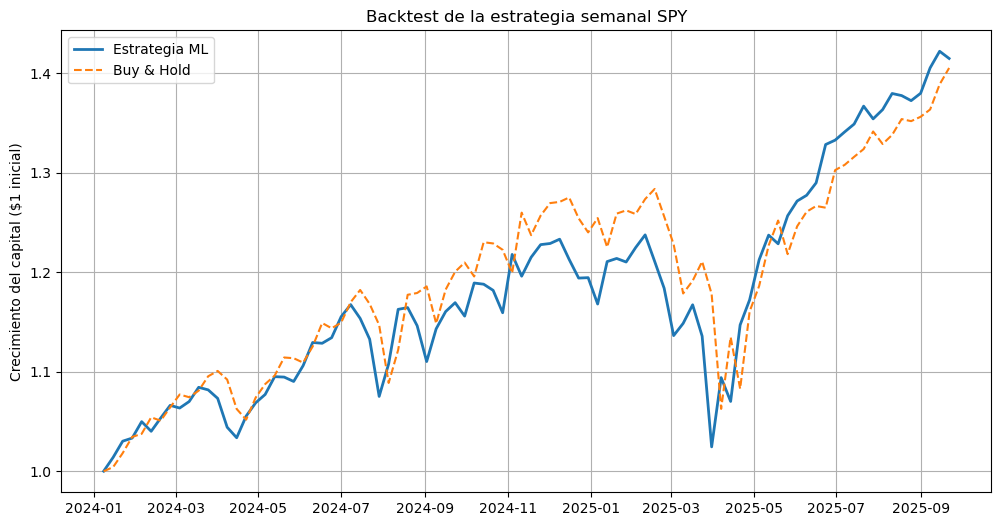

Resultados de la estrategia:
Retorno total: 41.48%
Semanas operadas (posición=1): 91
Semanas ganadoras: 62.22%


In [47]:
# ------------------------------------------------
# 1) Construir DataFrame con probabilidades y precios
# ------------------------------------------------
# - y_prob: las probabilidades predichas en Celda 3 (para el set de test).
# - Close: precio real de SPY en las mismas fechas.
signals = pd.DataFrame({
    'prob_up': y_prob,                            # probabilidad de que SPY suba
    'close': df_model['Close'].reindex(X_test.index)  # precios de cierre
}, index=X_test.index).dropna()

# ------------------------------------------------
# 2) Reagrupar por semanas (tomamos el valor del lunes como referencia)
# ------------------------------------------------
# resample('W-MON') => "semana terminada el lunes"
# .first() => tomamos la primera fila de esa semana (es decir, el lunes)
weekly_signals = signals.resample('W-MON').first()

# ------------------------------------------------
# 3) Generar la señal de trading
# ------------------------------------------------
# Si la probabilidad de subir es mayor a 0.55, entramos en posición (1),
# de lo contrario nos quedamos en efectivo (0).
weekly_signals['position'] = (weekly_signals['prob_up'] > 0.4).astype(int)

# ------------------------------------------------
# 4) Calcular retornos semanales (de lunes a viernes = 5 días hábiles)
# ------------------------------------------------
weekly_signals['price_in']  = df_model['Close'].reindex(weekly_signals.index, method="ffill")
weekly_signals['price_out'] = df_model['Close'].shift(-5).reindex(weekly_signals.index, method="ffill")
weekly_signals['return_5d'] = weekly_signals['price_out']/weekly_signals['price_in'] - 1

# ------------------------------------------------
# 5) Retorno de la estrategia
# ------------------------------------------------
# Solo obtenemos retorno si tenemos posición = 1.
gross_return = weekly_signals['return_5d'] * weekly_signals['position']

# ------------------------------------------------
# 6) Aplicar costos de operación
# ------------------------------------------------
COST = 0.0002  # 0.02% por cada lado (compra y venta)
# turnover = 1 cuando cambiamos de estado (de fuera a dentro o viceversa).
turnover = weekly_signals['position'].diff().abs().fillna(weekly_signals['position'].iloc[0])
# Restamos los costos de cada cambio (2*COST porque hay compra y venta)
net_return = gross_return - turnover*(2*COST)
net_return = net_return.dropna()

# ------------------------------------------------
# 7) Construir curva de capital acumulada
# ------------------------------------------------
equity_curve = (1 + net_return).cumprod()

# ------------------------------------------------
# 8) Comparación con Buy & Hold
# ------------------------------------------------
# Reindexamos los precios para que coincidan con las mismas semanas
bh_prices = df_model['Close'].reindex(equity_curve.index, method="ffill")
bh_curve = bh_prices / bh_prices.iloc[0]  # normalizamos para empezar en 1

# ------------------------------------------------
# 9) Graficar resultados
# ------------------------------------------------
plt.figure(figsize=(12,6))
plt.plot(equity_curve, label="Estrategia ML", linewidth=2)
plt.plot(bh_curve, label="Buy & Hold", linestyle="--")
plt.title("Backtest de la estrategia semanal SPY")
plt.ylabel("Crecimiento del capital ($1 inicial)")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------
# 10) Métricas básicas
# ------------------------------------------------
print("Resultados de la estrategia:")
print(f"Retorno total: {equity_curve.iloc[-1]-1:.2%}")
print(f"Semanas operadas (posición=1): {weekly_signals['position'].sum()}")
print(f"Semanas ganadoras: {(net_return>0).mean():.2%}")


# Probar la estrategia con otro modelo (Gradient Boosting)

Precisión en el conjunto de prueba (Gradient Boosting): 0.618


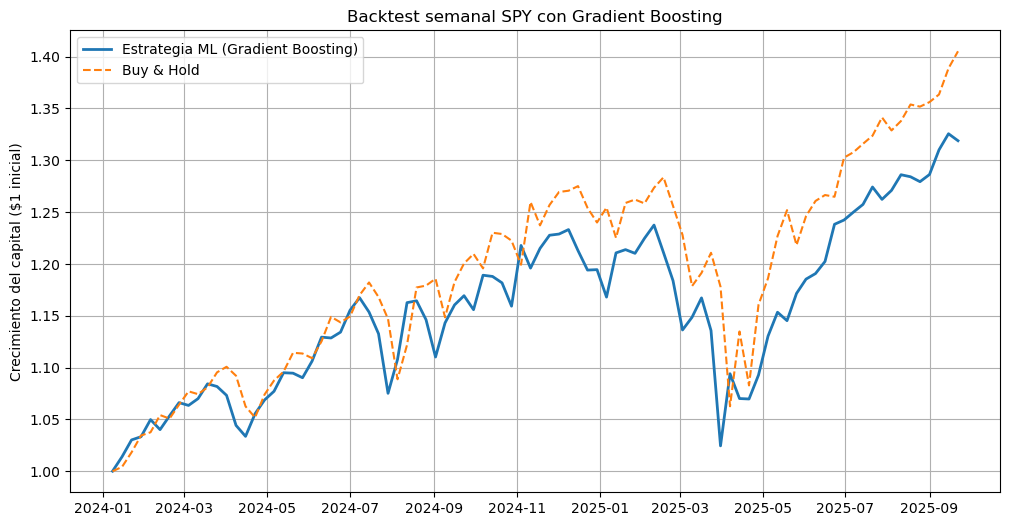

Resultados de la estrategia con Gradient Boosting:
Retorno total: 31.89%
Semanas operadas (posición=1): 90
Semanas ganadoras: 61.11%


In [48]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# ------------------------------------------------
# 1) Entrenar nuevo modelo
# ------------------------------------------------
gb_model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=3)
gb_model.fit(X_train, y_train)

# ------------------------------------------------
# 2) Predicciones en test
# ------------------------------------------------
y_pred_gb = gb_model.predict(X_test)
y_prob_gb = gb_model.predict_proba(X_test)[:,1]

# Métrica de precisión
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Precisión en el conjunto de prueba (Gradient Boosting): {accuracy_gb:.3f}")

# ------------------------------------------------
# 3) Backtest semanal con este modelo
# ------------------------------------------------
# Reutilizamos la misma lógica de la Celda 4, pero cambiando las probabilidades
signals_gb = pd.DataFrame({
    'prob_up': y_prob_gb,
    'close': df_model['Close'].reindex(X_test.index)
}, index=X_test.index).dropna()

weekly_signals_gb = signals_gb.resample('W-MON').first()
weekly_signals_gb['position'] = (weekly_signals_gb['prob_up'] > 0.4).astype(int)

weekly_signals_gb['price_in']  = df_model['Close'].reindex(weekly_signals_gb.index, method="ffill")
weekly_signals_gb['price_out'] = df_model['Close'].shift(-5).reindex(weekly_signals_gb.index, method="ffill")
weekly_signals_gb['return_5d'] = weekly_signals_gb['price_out']/weekly_signals_gb['price_in'] - 1

gross_return_gb = weekly_signals_gb['return_5d'] * weekly_signals_gb['position']

COST = 0.0002
turnover_gb = weekly_signals_gb['position'].diff().abs().fillna(weekly_signals_gb['position'].iloc[0])
net_return_gb = gross_return_gb - turnover_gb*(2*COST)
net_return_gb = net_return_gb.dropna()
equity_curve_gb = (1 + net_return_gb).cumprod()

# Comparación con Buy & Hold
bh_prices_gb = df_model['Close'].reindex(equity_curve_gb.index, method="ffill")
bh_curve_gb = bh_prices_gb / bh_prices_gb.iloc[0]

# ------------------------------------------------
# 4) Graficar curva comparativa
# ------------------------------------------------
plt.figure(figsize=(12,6))
plt.plot(equity_curve_gb, label="Estrategia ML (Gradient Boosting)", linewidth=2)
plt.plot(bh_curve_gb, label="Buy & Hold", linestyle="--")
plt.title("Backtest semanal SPY con Gradient Boosting")
plt.ylabel("Crecimiento del capital ($1 inicial)")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------
# 5) Métricas de la estrategia
# ------------------------------------------------
print("Resultados de la estrategia con Gradient Boosting:")
print(f"Retorno total: {equity_curve_gb.iloc[-1]-1:.2%}")
print(f"Semanas operadas (posición=1): {weekly_signals_gb['position'].sum()}")
print(f"Semanas ganadoras: {(net_return_gb>0).mean():.2%}")


Si usas > 0, tu curva de estrategia se convierte prácticamente en la misma línea que Buy & Hold, con una diferencia pequeña por el manejo de costos y la mecánica de “entrar el lunes y salir el viernes” en vez de mantener cada día.

# Probar la estrategia con otro modelo (Random Forest)

Precisión en el conjunto de prueba (Random Forest): 0.643


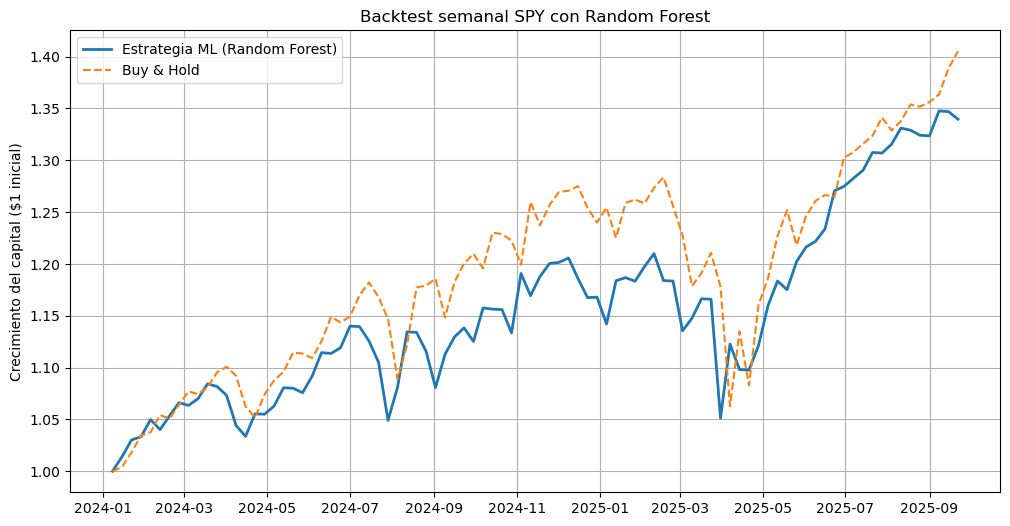

Resultados de la estrategia con Random Forest:
Retorno total: 33.97%
Semanas operadas (posición=1): 81
Semanas ganadoras: 55.56%


In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# ------------------------------------------------
# 1) Entrenar nuevo modelo
# ------------------------------------------------
# n_estimators = número de árboles
# max_depth = profundidad máxima (para evitar sobreajuste)
rf_model = RandomForestClassifier(n_estimators=300, max_depth=6, random_state=42)
rf_model.fit(X_train, y_train)

# ------------------------------------------------
# 2) Predicciones en test
# ------------------------------------------------
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:,1]

# Precisión
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Precisión en el conjunto de prueba (Random Forest): {accuracy_rf:.3f}")

# ------------------------------------------------
# 3) Backtest semanal con este modelo
# ------------------------------------------------
signals_rf = pd.DataFrame({
    'prob_up': y_prob_rf,
    'close': df_model['Close'].reindex(X_test.index)
}, index=X_test.index).dropna()

weekly_signals_rf = signals_rf.resample('W-MON').first()
weekly_signals_rf['position'] = (weekly_signals_rf['prob_up'] > 0.55).astype(int)

weekly_signals_rf['price_in']  = df_model['Close'].reindex(weekly_signals_rf.index, method="ffill")
weekly_signals_rf['price_out'] = df_model['Close'].shift(-5).reindex(weekly_signals_rf.index, method="ffill")
weekly_signals_rf['return_5d'] = weekly_signals_rf['price_out']/weekly_signals_rf['price_in'] - 1

gross_return_rf = weekly_signals_rf['return_5d'] * weekly_signals_rf['position']

COST = 0.0002
turnover_rf = weekly_signals_rf['position'].diff().abs().fillna(weekly_signals_rf['position'].iloc[0])
net_return_rf = gross_return_rf - turnover_rf*(2*COST)
net_return_rf = net_return_rf.dropna()
equity_curve_rf = (1 + net_return_rf).cumprod()

# Comparación con Buy & Hold
bh_prices_rf = df_model['Close'].reindex(equity_curve_rf.index, method="ffill")
bh_curve_rf = bh_prices_rf / bh_prices_rf.iloc[0]

# ------------------------------------------------
# 4) Graficar curva comparativa
# ------------------------------------------------
plt.figure(figsize=(12,6))
plt.plot(equity_curve_rf, label="Estrategia ML (Random Forest)", linewidth=2)
plt.plot(bh_curve_rf, label="Buy & Hold", linestyle="--")
plt.title("Backtest semanal SPY con Random Forest")
plt.ylabel("Crecimiento del capital ($1 inicial)")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------
# 5) Métricas de la estrategia
# ------------------------------------------------
print("Resultados de la estrategia con Random Forest:")
print(f"Retorno total: {equity_curve_rf.iloc[-1]-1:.2%}")
print(f"Semanas operadas (posición=1): {weekly_signals_rf['position'].sum()}")
print(f"Semanas ganadoras: {(net_return_rf>0).mean():.2%}")


In [50]:
import numpy as np


def calculate_metrics(curve, risk_free_rate=0.01):
    returns = curve.pct_change().dropna()
    total_periods = len(curve)
    years = (curve.index[-1] - curve.index[0]).days / 365.25

    # CAGR
    cagr = (curve.iloc[-1] / curve.iloc[0]) ** (1 / years) - 1

    # Volatilidad anualizada
    volatility = returns.std() * np.sqrt(52)  # semanal

    # Sharpe Ratio
    sharpe = (cagr - risk_free_rate) / volatility if volatility != 0 else np.nan

    # Sortino Ratio
    downside = returns[returns < 0].std() * np.sqrt(52)
    sortino = (cagr - risk_free_rate) / downside if downside != 0 else np.nan

    # Max Drawdown
    rolling_max = curve.cummax()
    drawdown = curve / rolling_max - 1
    max_dd = drawdown.min()

    return {
        'CAGR': cagr,
        'Volatility': volatility,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Max Drawdown': max_dd
    }

# Calcular métricas para ambas curvas
metrics_active = calculate_metrics(equity_curve)
metrics_bh = calculate_metrics(bh_curve)

# Mostrar resultados
print("\n📈 Métricas de la estrategia activa:")
for k, v in metrics_active.items():
    print(f"{k}: {v:.2%}")

print("\n📊 Métricas de Buy & Hold:")
for k, v in metrics_bh.items():
    print(f"{k}: {v:.2%}")


📈 Métricas de la estrategia activa:
CAGR: 22.55%
Volatility: 16.70%
Sharpe Ratio: 129.03%
Sortino Ratio: 160.62%
Max Drawdown: -17.21%

📊 Métricas de Buy & Hold:
CAGR: 22.07%
Volatility: 16.95%
Sharpe Ratio: 124.32%
Sortino Ratio: 146.54%
Max Drawdown: -17.21%
